<a href="https://colab.research.google.com/github/dymiyata/erdos2023_million_playlist_challenge/blob/master/matrix_factorization/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import json
import copy
import random
from numba import njit

import sqlalchemy as db

from time import time
from datetime import timedelta

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Define functions

## Loading data

In [2]:
# Define a function to load the playlist table from the SQL database into the array R_list
def make_R_list_sql(conn, pid_limit=None, progress=5., fetch_size=10**6):
    if pid_limit is None:
        # Get number of pairings
        results = conn.execute(db.text("SELECT COUNT(*) FROM pairings"))
        N = results.fetchall()[0][0]
        
        # Get columns one by one
        results = conn.execute(db.text("SELECT pid, tid FROM pairings"))
    else:
        # Get number of pairings
        results = conn.execute(db.text(f"SELECT COUNT(*) FROM pairings WHERE pid<{pid_limit}"))
        N = results.fetchall()[0][0]
        
        # Get columns one by one
        results = conn.execute(db.text(f"SELECT pid, tid FROM pairings WHERE pid<{pid_limit}"))
    
    R_list = np.empty((N,2), dtype=int)
    
    i = 0
    time_0 = time()
    show_progress = False
    old_i = 0
    divisor = np.round(N*progress/100)
    while rows:=results.fetchmany(fetch_size):
        if progress is not None:
            # Show progress
            if i/divisor > old_i/divisor:
                time_t = time()
                print('{:.2f}%: {:.2f} sec'.format(i/N*100, time_t-time_0))
                
                time_0 = time_t
                old_i = i
        
        for row in rows:
            R_list[i,0] = int(row[0])
            R_list[i,1] = int(row[1])
            i+=1
    
    return R_list

## Formatting

In [3]:
# Create two dicts such that:
# - idx_to_elt gives the i-th element in the sorted list
# - elt_to_idx gives the position of elt in the sorted list
# We can afford to store this information rather than recomputing it every time
def list_to_dict(new_list):
    # We only care about unique elements
    # Also, np.unique returns the sorted list
    new_list = np.unique(new_list)
    
    elt_to_idx = {}
    idx_to_elt = {}
    
    idx=0
    for elt in new_list:
        idx_to_elt[idx] = elt
        elt_to_idx[elt] = idx
        
        idx+=1
    
    return elt_to_idx, idx_to_elt

# Replaces each entry of R_list with its indices as given by pid_to_idx and tid_to_idx
def array_to_idx(R_list, pid_to_idx, tid_to_idx):
    R_list_idx = np.empty( R_list.shape, dtype=int)
    
    for row in range(R_list.shape[0]):
        R_list_idx[row,0] = pid_to_idx[ R_list[row,0] ]
        R_list_idx[row,1] = tid_to_idx[ R_list[row,1] ]
    
    return R_list_idx

# Format an unseen R_list to be processed in our pipeline
# We can only process songs that are in tid_to_idx already, so we remove those we don't know
def format_new_R_list(R_list_new, tid_to_idx):
    # Remove tracks that we don't recognize
    tid_known = list(tid_to_idx.keys())
    R_list_new = R_list_new[ np.isin(R_list_new[:,1], tid_known), : ]
    
    pid_to_idx, idx_to_pid = list_to_dict(R_list_new[:,0])
    
    R_idx_new = array_to_idx(R_list_new, pid_to_idx, tid_to_idx)
    
    return R_list_new, R_idx_new, pid_to_idx, idx_to_pid

## Gradient descent
The functions for running gradient descent and computing the error function

In [4]:
# Run an epoch of gradient descent where the iterations parameter is the number of iterations.
@njit
def run_epoch(R_idx_list, P, Q, alpha, llambda, iterations):
    oldP = P.copy()
    oldQ = Q.copy()
    f = np.shape(P)[1]
    
    for _ in range(iterations):
        newP = oldP.copy()
        newQ = oldQ.copy()
        for u,i in R_idx_list:
            dotprod = 0
            for feature in range(f):
                dotprod += oldP[u,feature] * oldQ[i,feature]
            error = dotprod - 1

            for feature in range(f):
                pf = oldP[u,feature]
                qf = oldQ[i,feature]
                newP[u,feature] -= alpha * (error * qf + llambda * pf) 
                newQ[i,feature] -= alpha * (error * pf + llambda * qf)
        oldP = newP
        oldQ = newQ
    return newP, newQ

@njit
def MSE(R_list, P, Q):
    result = 0
    
    # sum over R_list
    for pid, tid in R_list:
        result += (1 - P[pid,:]@Q[tid,:])**2
    
    return result

@njit
# MSE with L2 regularization
def error_function_l2(R_list, P , Q, llambda):
    result = 0
    
    #sum over R_list
    for row, col in R_list:
        result += (1 - P[row,:]@Q[col,:])**2
    
    result += llambda * (np.linalg.norm(P)**2 + np.linalg.norm(Q)**2)
    return result

The function for obtaining the playlist vector that minimizes the cost function for a fixed $Q$ from a list of track id's.

In [5]:
@njit
def new_user_vec(Y, llambda):
    d,f = np.shape(Y)
    vec = np.linalg.inv(np.transpose(Y) @ Y + llambda * np.identity(f)) @ np.transpose(Y) @ np.ones((d,1))
    return np.transpose(vec)

@njit
def make_Pval(R_list_new, Q, llambda):
    _, f = np.shape(Q)
    
    new_pids = np.unique(R_list_new[:,0])
    P_val = np.zeros((len(new_pids), f))
    
    for pid in new_pids:
        # get list of tracks in the playlist
        tid_list = R_list_new[ R_list_new[:,0]==pid, 1]

        # x is the row of Pval corresponding to this pid
        x = new_user_vec(Q[tid_list,:], llambda)
        
        for feature in range(f):
            P_val[pid, feature] = x[0,feature]
        
    return P_val

# Training the Model

Load the SQL database

In [6]:
db_path = "sqlite:///../spotify_sql_with_tid_0.db"
engine = db.create_engine(db_path)
conn = engine.connect()

In [7]:
time_0 = time()
R_list = make_R_list_sql(conn, pid_limit=10000, progress=10)
time_end = time()

print('{:.3f} sec'.format(time_end-time_0))
print('{:.3f} minutes'.format((time_end-time_0)/60))
print()

num_playlists = len(np.unique(R_list[:,0]))
print(f'We have {num_playlists} playlists')

7.701 sec
0.128 minutes

We have 10000 playlists


Create train-test split

In [8]:
# Percentage of the total database to reserve for validation and testing
val_size_abs = 0.15
test_size    = 0.15
shuffle = True

# Note: the first pid_train contains (1-test_size) percent of the data.
# We need to use val_size so that val_size*(1-test_size) = val_size_abs.
val_size = val_size_abs/(1-test_size)
pid_train, pid_test = train_test_split(np.arange(num_playlists), test_size=test_size,
                                       shuffle=shuffle, random_state=11)
pid_train, pid_val  = train_test_split(pid_train, test_size=val_size,
                                       shuffle=shuffle, random_state=11)

# Show the first few entries of pid_train
print('Verify the following two lists are equal:')
print(pid_train[:7])
print(np.array([597571, 679779, 758502, 28851, 480077, 430444, 982068]))

Verify the following two lists are equal:
[1722 1255 4053 4618 8312 4839 4278]
[597571 679779 758502  28851 480077 430444 982068]


In [75]:
R_list_train = R_list[ np.isin(R_list[:,0], pid_train), :]
R_list_val   = R_list[ np.isin(R_list[:,0], pid_val),   :]
R_list_test  = R_list[ np.isin(R_list[:,0], pid_test),  :]
R_list_full  = np.concatenate( (R_list_train, R_list_val))

# Store the track id of songs in the train/val/test sets
tid_train = np.unique( R_list_train[:,1] )
tid_val   = np.unique( R_list_val[:,1]   )
tid_test  = np.unique( R_list_test[:,1]  )

num_playlists = len(pid_train)
num_songs = len(tid_train)

print('Number of training playlists:', num_playlists)
print('Number of training songs:', num_songs)

Number of training playlists: 7000
Number of training songs: 134357


We create new variables so that the `tid`s in the `R_idx_*` match with the indices of tracks in the `Q` matrix everywhere

In [76]:
tid_to_idx, _ = list_to_dict(tid_train)

# Remove tracks we don't know from the validation and test sets
# Create new arrays with consecutive tids
# And store the dicts to go from the original pid-tid labeling to the new consecutive indexing
_,           R_train_idx, _,   _  = format_new_R_list(R_list_train, tid_to_idx)
R_list_val,  R_val_idx,   _,   _  = format_new_R_list(R_list_val,  tid_to_idx)
R_list_test, R_test_idx,  pid_to_idx_test,  idx_to_pid_test  = format_new_R_list(R_list_test,  tid_to_idx)

R_list_full, R_full_idx,  pid_to_idx_full,  idx_to_pid_full  = format_new_R_list(R_list_full,  tid_to_idx)

# Example of training the algorithm

Specify the number of features and create matrices $P$ and $Q$ whose entries are randomly taken from a normal distribution with $\mu = 0$ and $\sigma = 0.1$.

In [11]:
f = 10 # number of latent features
# num_songs = max(reverse_track_dict.keys()) + 1
num_songs = len(tid_train)
num_playlists = len(pid_train)

# initialize random values for matrices P and Q. Entries are between -1 and 1
P = np.random.normal(0, 0.1, (num_playlists, f))
Q = np.random.normal(0, 0.1, (num_songs, f))

Run the gradient descent algorithm and store the resulting matrices in P_trained and Q_trained.

In [46]:
# Run gradient descent algorithm with alpha = 0.001, llambda = 0.005 for 100 iterations
start_time = time()
P_trained, Q_trained = run_epoch(R_train_idx, P, Q, 0.001, 0.005, 100)
end_time = time()
print('Training done: {:.3f} sec'.format(end_time-start_time))

Training done: 3.956 sec


In [47]:
Q_trained

array([[-0.20523416,  0.05141345,  0.15402769, ...,  0.10298745,
         0.04054327,  0.04400497],
       [-0.01634108,  0.08450744,  0.02457291, ...,  0.01645157,
         0.0200186 , -0.03340193],
       [-0.21380995, -0.22486889, -0.12653225, ..., -0.09619723,
        -0.05161501, -0.07585662],
       ...,
       [ 0.1068875 ,  0.03390851,  0.02614311, ..., -0.06347865,
         0.05474985,  0.16148494],
       [ 0.16627533, -0.14142665, -0.06660446, ...,  0.11931262,
         0.23330267,  0.0115071 ],
       [-0.1927208 , -0.12406706, -0.07629527, ..., -0.07903929,
         0.01626884,  0.18872745]])

For our fixed Q, given a list of (new) playlist ids, we can compute the P matrix that minimizes the training error

In [ ]:
# Run gradient descent algorithm with alpha = 0.001, llambda = 0.005 for 100 iterations
start_time = time()
P_val = make_Pval(R_idx_val, Q_trained, 0.005)
print('MSE:', MSE(R_idx_val, P_val, Q_trained))
end_time = time()

print('Done: {:.3f} sec'.format(end_time-start_time))

# Find best hyperparameters using grid search

Define functions to try generic combinations of parameters.

In [99]:
# Use grid search to compute the validation cost for all combinations of values of f, alpha, and llambda
def grid_search(f_values, alpha_values, llambda_values, NUM_ITERATIONS):
    nF = len(f_values)
    nA = len(alpha_values)
    nL = len(llambda_values)
    costs = np.zeros((nF,nA,nL))
    
    # Execute grid search
    time_start = 0
    for idf in range(nF):
        f = f_values[idf]
        for ida in range(nA):
            alpha = alpha_values[ida]
            for idl in range(nL):
                llambda = llambda_values[idl]

                time_0 = time()
                iter_count = nA*nL*idf + nL*ida + idl+1
                print(f'Processing {iter_count}/{nF*nA*nL}:')
                print(f'({idf+1},{ida+1},{idl+1})/({nF},{nA},{nL})')
                error = False

                # Initialize random values
                P_initial = np.random.normal(0, 0.1, (num_playlists, f))
                Q_initial = np.random.normal(0, 0.1, (num_songs, f))

                # Obtain P, Q with the chosen hyperparameters
                P_trained, Q_trained = run_epoch(R_train_idx, P=P_initial, Q=Q_initial, alpha=alpha, llambda=llambda, iterations=NUM_ITERATIONS)
                
                # Skip iteration if Q_trained contains a nan
                if np.isnan(Q_trained).any():
                    costs[idf,ida,idl] = np.nan
                    error = True
                else:
                    # Check results against the validation set
                    P_val = make_Pval(R_idx_val, Q_trained, llambda)
                    costs[idf,ida,idl] = MSE(R_idx_val, P_val, Q_trained)
                
                # Show progress
                time_t = time()
                
                print('Duration:  ', end=' ')
                print(str( timedelta(seconds=time_t-time_0) )[:-4])
                print('Total time:', end=' ')
                print(str( timedelta(seconds=time_t-time_start) )[:-4])
                
                if error:
                    print('-- Failed -- found nan')
                print()
    
    return costs

# Plot the errors found by grid_search
def plot_grid_search(costs, f_values, alpha_values, llambda_values):
    nF = len(f_values)
    nA = len(alpha_values)
    nL = len(llambda_values)
    
    # Plot results
    for ida in range(nA):
        for idl in range(nL):
            alpha = '{:.1E}'.format(alpha_values[ida])
            llambda = '{:.1E}'.format(llambda_values[idl])

            cost_f = costs[:,ida,idl]
            plt.plot(f_values, cost_f, '.', label=(alpha,llambda))
            
            """
            idt = 0
            display = True
            while np.isnan(cost_f[idt]):
                idt += 1
                if idt == nL:
                    display = False
                    break
            if display:
                plt.text(f_values[0], cost_f[0], str((alpha,llambda)))
            """

    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of latent features')

    print('Additional parameters:')
    print('Alpha values:', alpha_values)
    print('llambda values:', llambda_values)

## Logs of attempts
Here, I'll be trying several combinations of hyperparameters. I'll keep a record of what has and hasn't worked.
1. With 100 iterations, small values of alpha (`10**-5` and `10**-4`) have too much error. 
2. With larger values (`10**-2` and up), run_epoch does not converge (Q_trained is a matrix of nans).
    - Maybe increasing the number of iterations helps smaller alphas.

Thus, we **fix `alpha=10**(-3)`**.

3. With $5 \leq f < 20$ and `llambda` ranging from `10**-5` to `10**-1`, the error decreases with `f`, but it's not clear which `llambda` is best. We do learn that `llambda = 10**-1` doesn't work as well.

4. The cost keeps decreasing with the number of features.

5. I'll try increasing the number of iterations to 500 with a smaller number of features. Maybe this performes better than larger models with small number of iterations.

6. 500 iterations vastly improves the model. Let's try more.

In [98]:
# Hyperparameter tuning using grid search
NUM_ITERATIONS = 1000

# Specify the number of latent features (f), learning rate (alpha), and regularization parameter (llambda)
f_values = np.arange(5,10)
alpha_values = np.array([10**-3])
llambda_values = 10.**np.arange(-5,-1)
costs = grid_search(f_values, alpha_values, llambda_values, NUM_ITERATIONS)

Processing 1/20:
(1,1,1)/(5,1,4)
Duration:   0:00:18.55
Total time: 0:00:18.55

Processing 2/20:
(1,1,2)/(5,1,4)
Duration:   0:00:17.99
Total time: 0:00:36.55

Processing 3/20:
(1,1,3)/(5,1,4)
Duration:   0:00:17.34
Total time: 0:00:53.89

Processing 4/20:
(1,1,4)/(5,1,4)
Duration:   0:00:17.81
Total time: 0:01:11.71

Processing 5/20:
(2,1,1)/(5,1,4)
Duration:   0:00:21.67
Total time: 0:01:33.39

Processing 6/20:
(2,1,2)/(5,1,4)
Duration:   0:00:22.41
Total time: 0:01:55.81

Processing 7/20:
(2,1,3)/(5,1,4)
Duration:   0:00:23.30
Total time: 0:02:19.11

Processing 8/20:
(2,1,4)/(5,1,4)
Duration:   0:00:22.68
Total time: 0:02:41.79

Processing 9/20:
(3,1,1)/(5,1,4)
Duration:   0:00:27.35
Total time: 0:03:09.15

Processing 10/20:
(3,1,2)/(5,1,4)
Duration:   0:00:27.70
Total time: 0:03:36.86

Processing 11/20:
(3,1,3)/(5,1,4)
Duration:   0:00:27.65
Total time: 0:04:04.51

Processing 12/20:
(3,1,4)/(5,1,4)
Duration:   0:00:28.76
Total time: 0:04:33.28

Processing 13/20:
(4,1,1)/(5,1,4)
Dur

Additional parameters:
Alpha values: [0.001]
llambda values: [1.e-05 1.e-04 1.e-03 1.e-02]


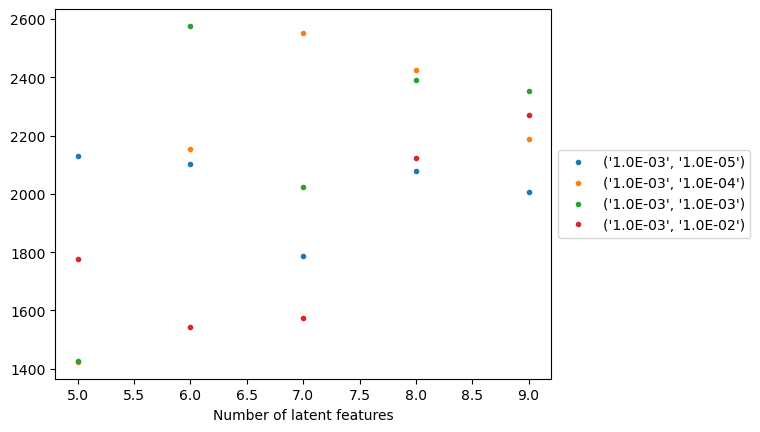

In [100]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

## Plots of several attempts
The order of the plots is reversed with respect to the explanations above

Additional parameters:
Alpha values: [0.001]
llambda values: [1.e-05 1.e-04 1.e-03 1.e-02]


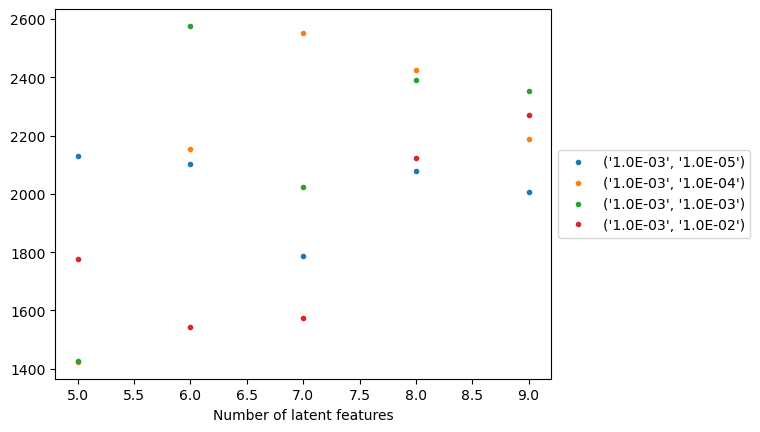

In [100]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

Additional parameters:
Alpha values: [0.001]
llambda values: [1.e-05 1.e-04 1.e-03 1.e-02]


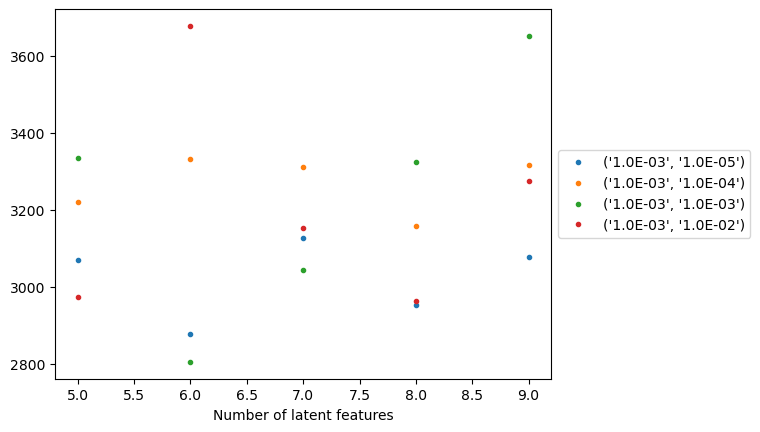

In [97]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

Additional parameters:
Alpha values: [0.001]
llambda values: [1.e-05 1.e-04 1.e-03 1.e-02]


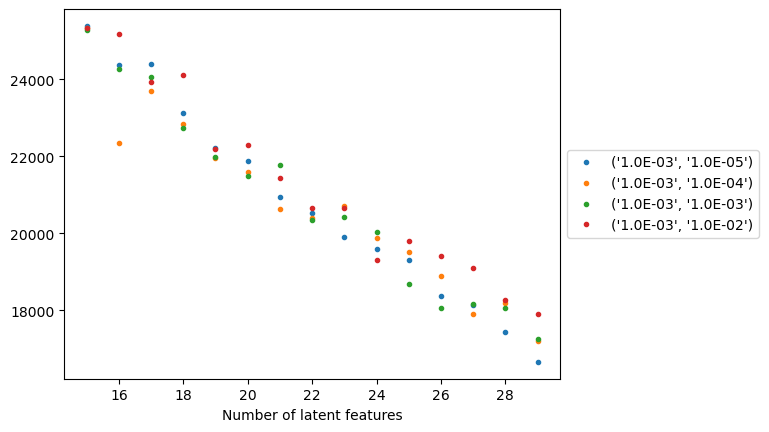

In [95]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

Additional parameters:
Alpha values: [0.001]
llambda values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]


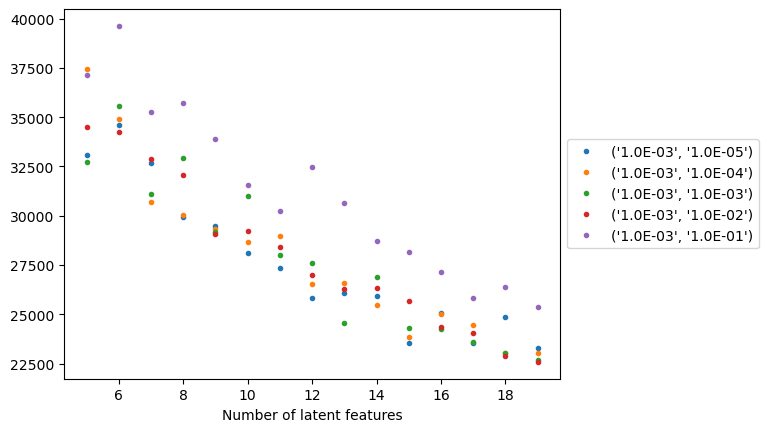

In [92]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

Additional parameters:
Alpha values: [0.001 0.01  0.1  ]
llambda values: [0.01 0.1 ]


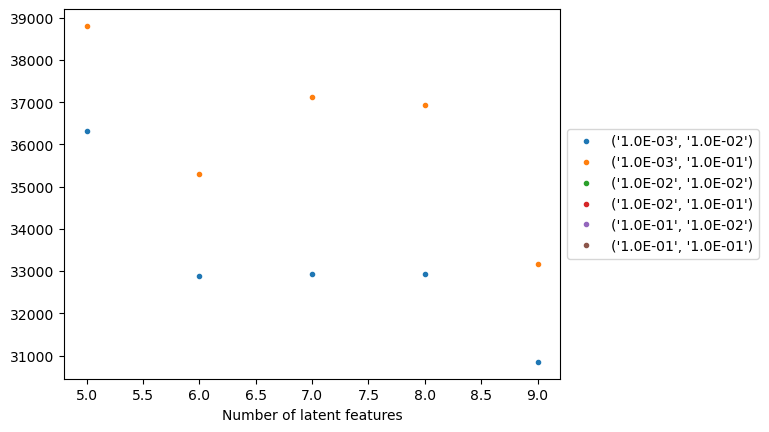

In [89]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

Additional parameters:
Alpha values: [1.e-05 1.e-04 1.e-03]
llambda values: [0.01 0.1 ]


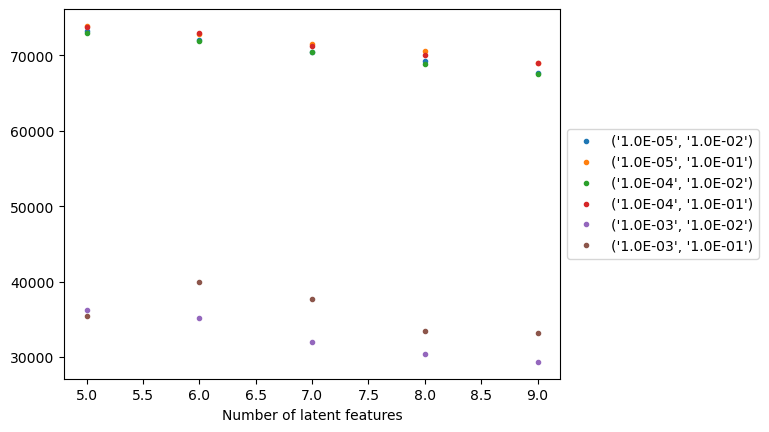

In [86]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)

# Train the chosen model

In [101]:
# Choose hyperparameters
f = 6
alpha = 10**-3
llambda = 10**-3

NUM_ITERATIONS = 1000

In [ ]:
R_train_full = np.concatenate( (R_list_train,R_list_val) )
R_train_full, R_full_idx, pid_to_idx, idx_to_pid = format_new_R_list(R_train_full, tid_to_idx)

# Initialize random data
P_initial = np.random.normal(0, 0.1, (num_playlists, f))
Q_initial = np.random.normal(0, 0.1, (num_songs, f))

# Obtain P, Q with the chosen hyperparameters
time_start = time()
P_trained, Q_trained = run_epoch(R_list_train, P=P_initial, Q=Q_initial, alpha=alpha, llambda=llambda, iterations=NUM_ITERATIONS)
time_end = time()
print('Training"', str( timedelta(seconds=time_end-time_start) )[:-4])